In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import random
from sklearn.utils import shuffle


## Data

In [2]:
#train = np.load('/content/drive/MyDrive/EEG_sleep_analisys/train_samples.win500.npy', allow_pickle=True)
#test = np.load('/content/drive/MyDrive/EEG_sleep_analisys/two_stage_test.npy', allow_pickle=True)
train = np.load('train_samples.win500.npy', allow_pickle=True)
test = np.load('two_stage_test.npy', allow_pickle=True)

In [3]:
df = pd.DataFrame.from_records(train)
test_df = pd.DataFrame.from_records(test)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324552 entries, 0 to 324551
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   324552 non-null  object
 1   time    324552 non-null  object
 2   value   324552 non-null  object
 3   person  324552 non-null  object
dtypes: object(4)
memory usage: 9.9+ MB


In [5]:
df.head()

,label,time,value,person
0,Sleep stage W,0,"[[-72.44151404151403, 1.0683760683760717], [-7...",SC4022
1,Sleep stage W,5,"[[-8.093772893772893, 2.3504273504273536], [-1...",SC4022
2,Sleep stage W,10,"[[62.52039072039072, 7.136752136752141], [70.4...",SC4022
3,Sleep stage W,15,"[[-3.2302808302808286, 1.2393162393162427], [-...",SC4022
4,Sleep stage W,20,"[[-12.770207570207567, -12.094017094017088], [...",SC4022


In [6]:
sleep_stages = df.label.unique()
sleep_stages

array(['Sleep stage W', 'Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3',
       'Sleep stage 4', 'Sleep stage R', 'Movement time', 'Sleep stage ?'],
      dtype=object)

Оставим только нужные классы

In [7]:
df = df[(df.label != 'Sleep stage R') & (df.label != 'Movement time') & (df.label != 'Sleep stage ?')]

In [8]:
def get_first_value(value: np.ndarray) -> np.ndarray:
  return np.transpose(value)[0]
def get_second_value(value: np.ndarray) -> np.ndarray:
  return np.transpose(value)[1]

df['first_value'] = df.value.apply(get_first_value)
df['second_value'] = df.value.apply(get_second_value)

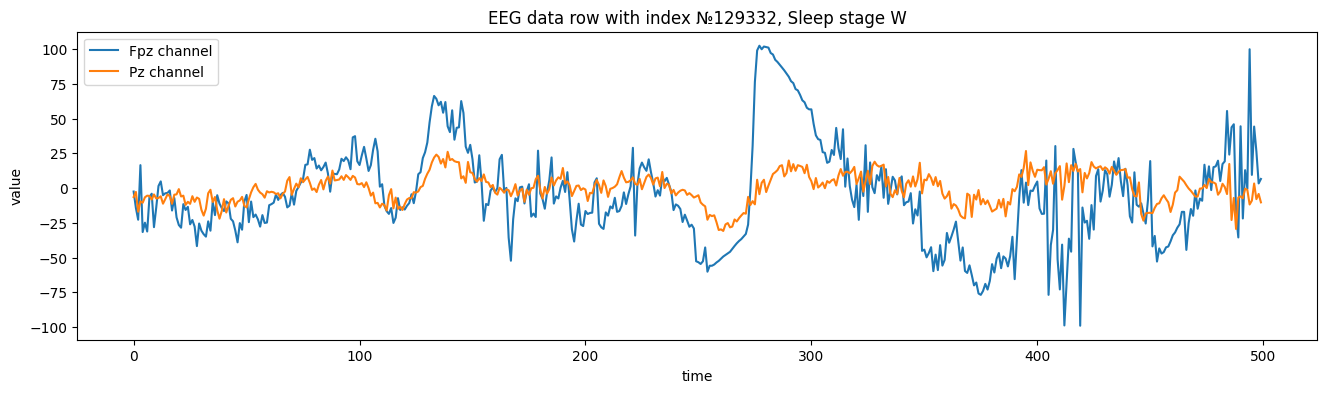

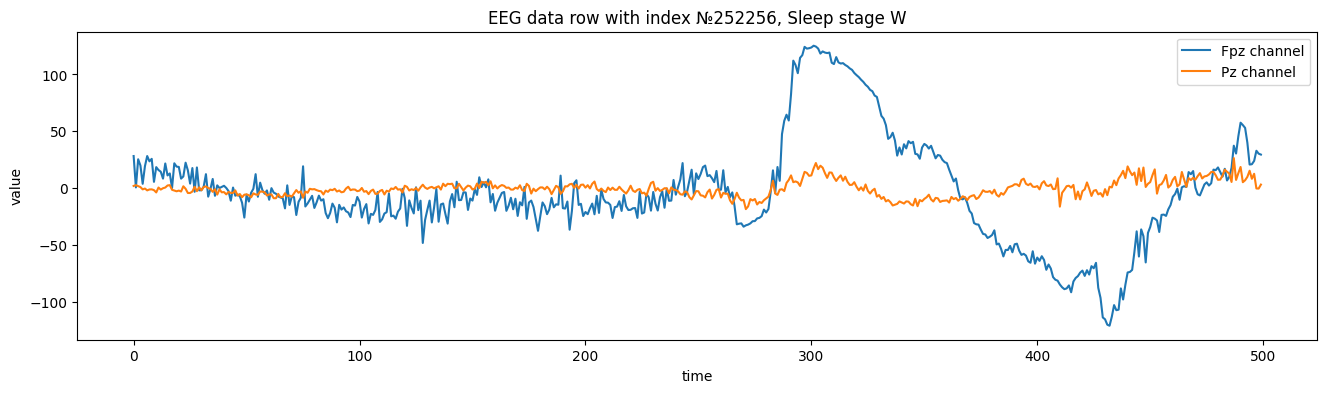

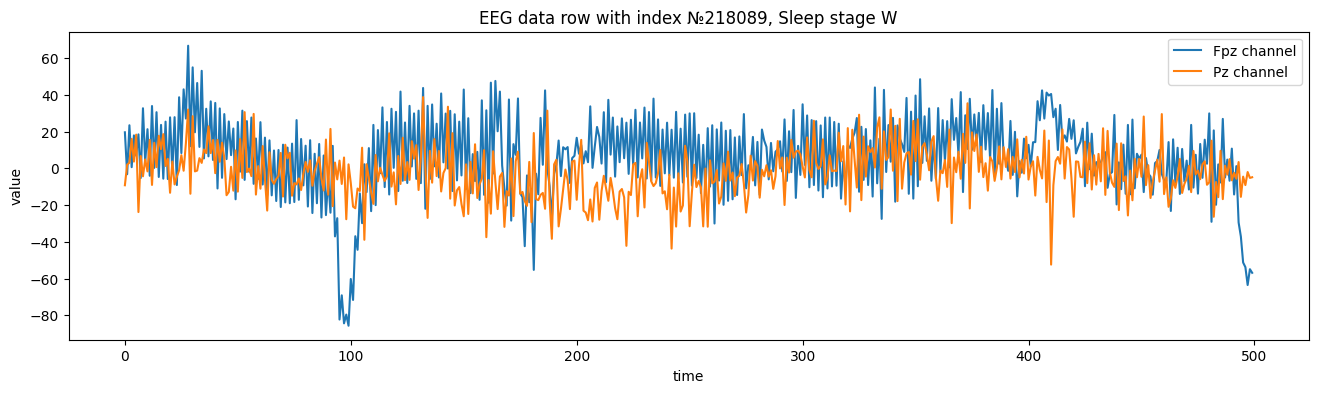

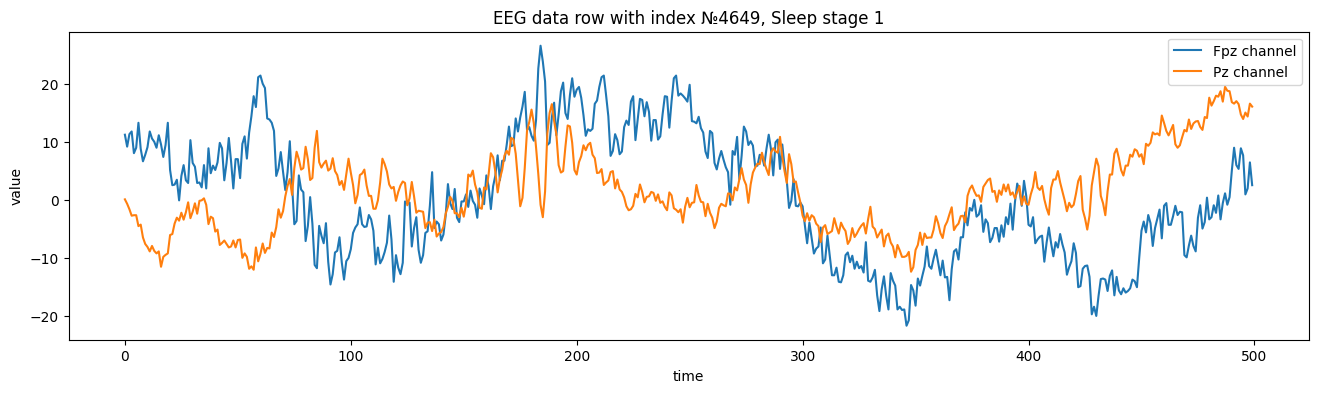

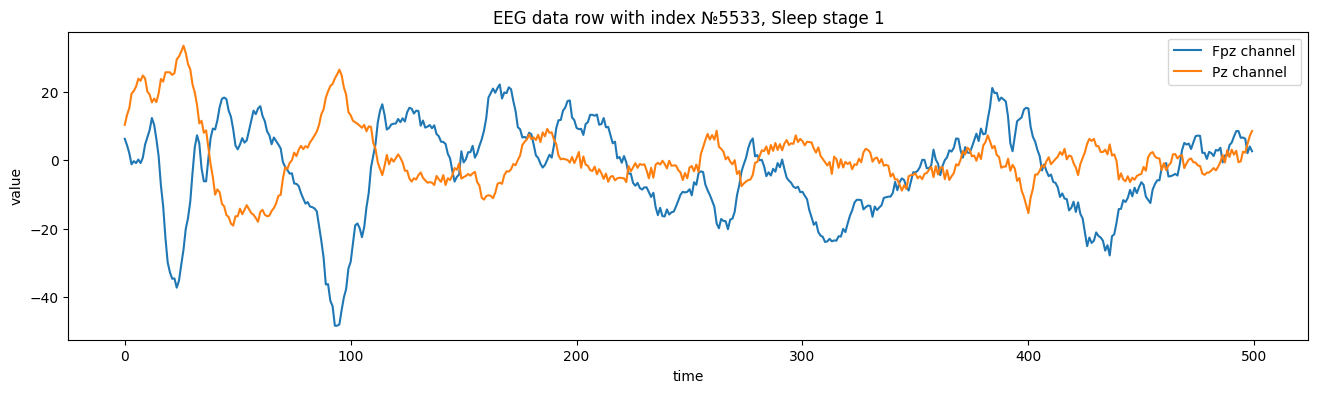

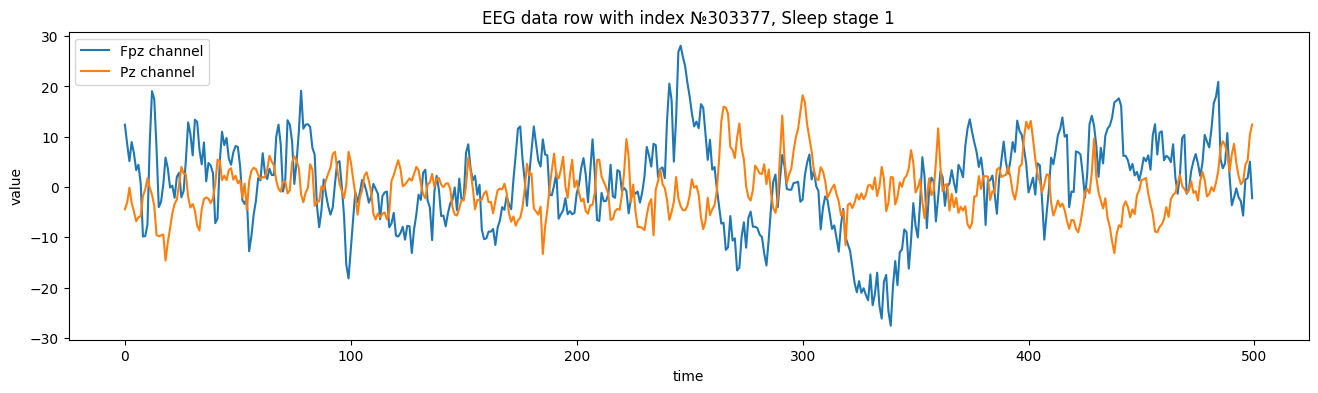

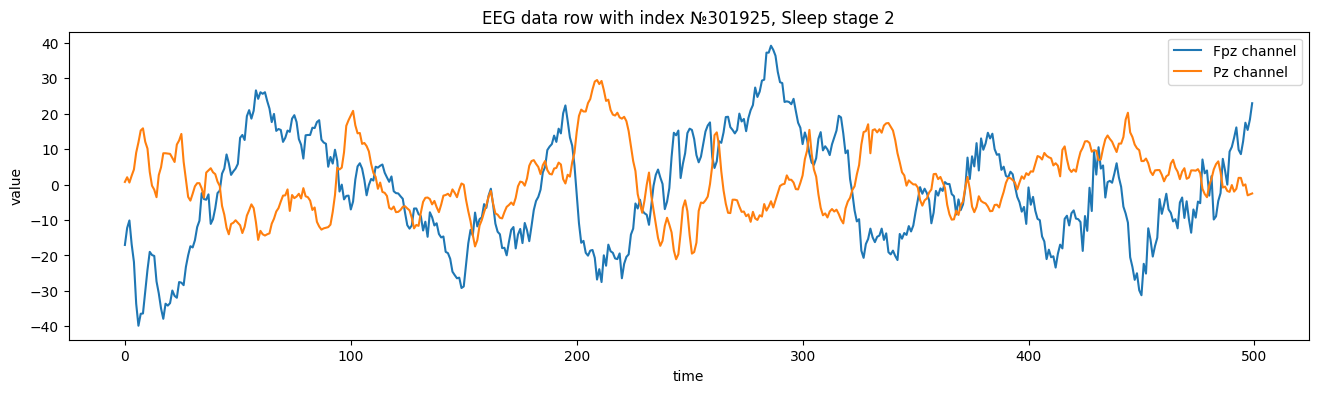

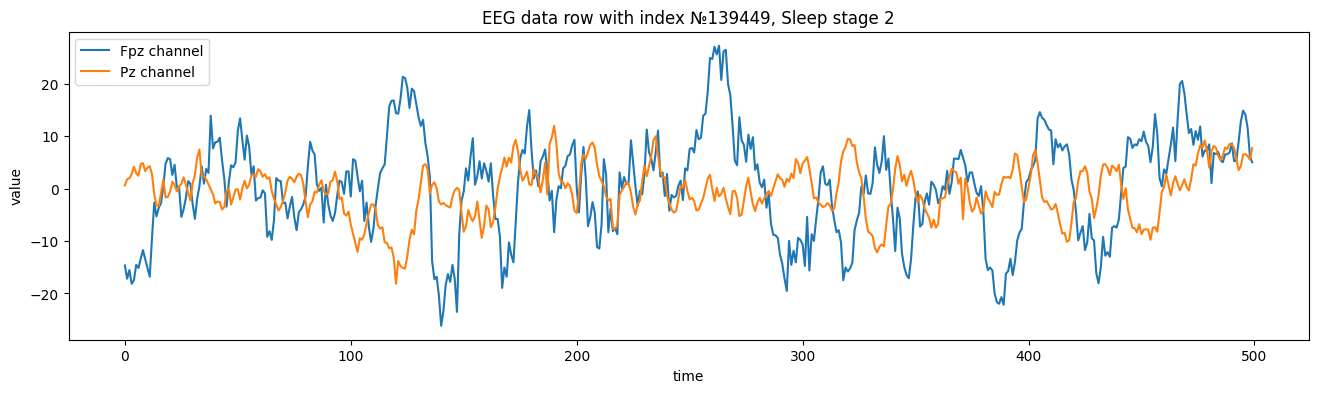

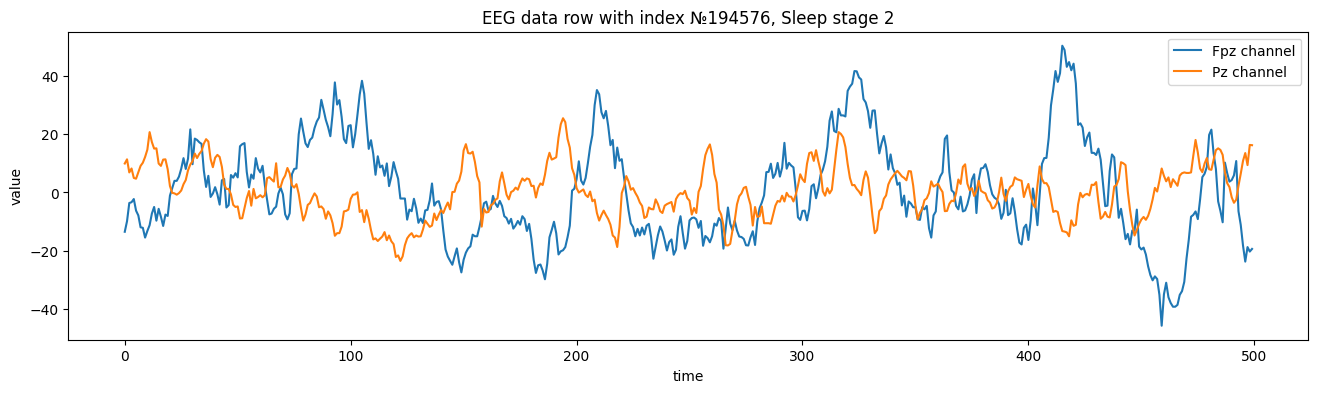

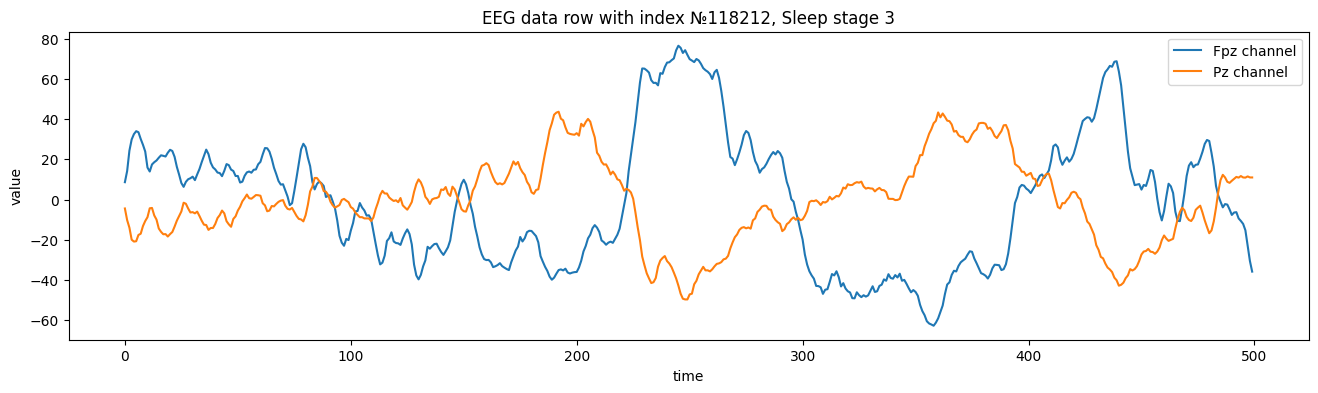

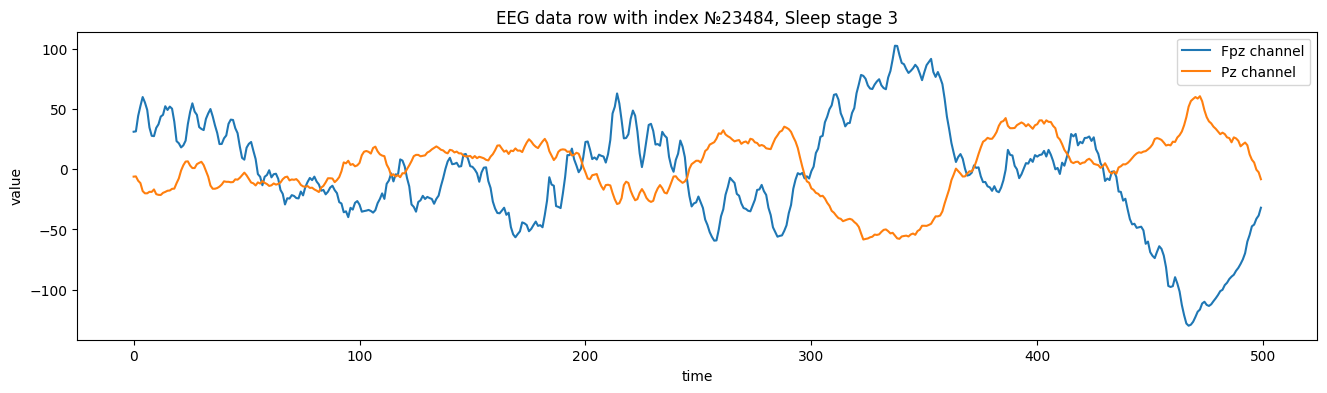

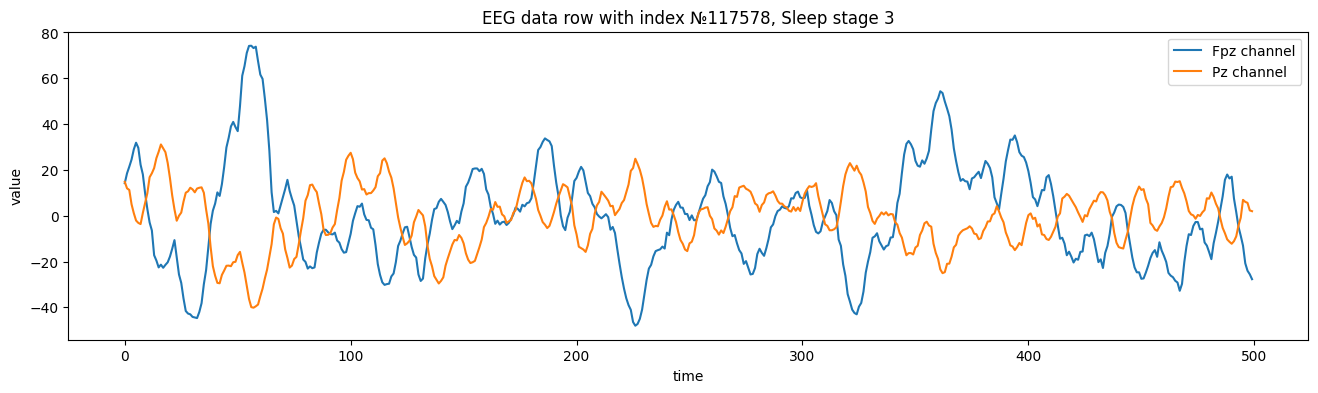

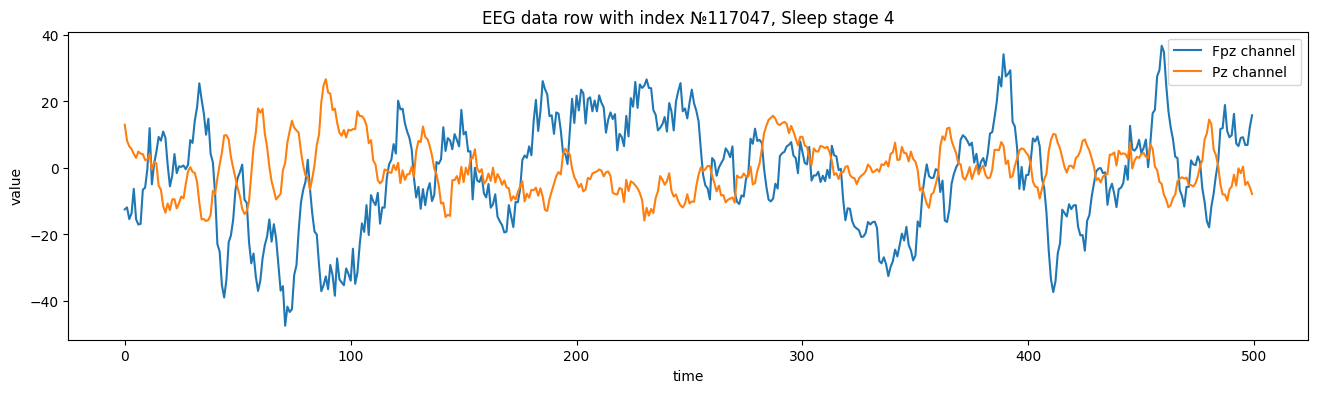

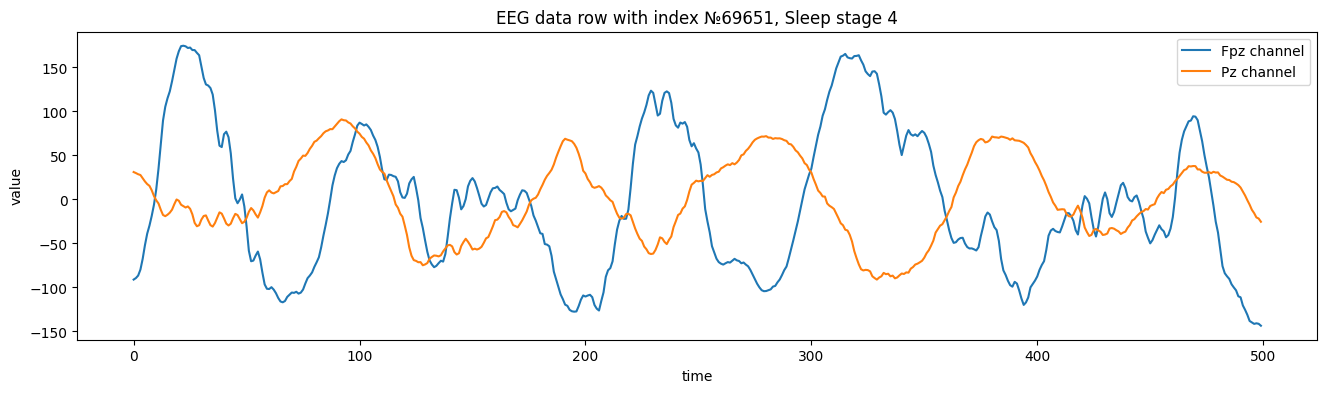

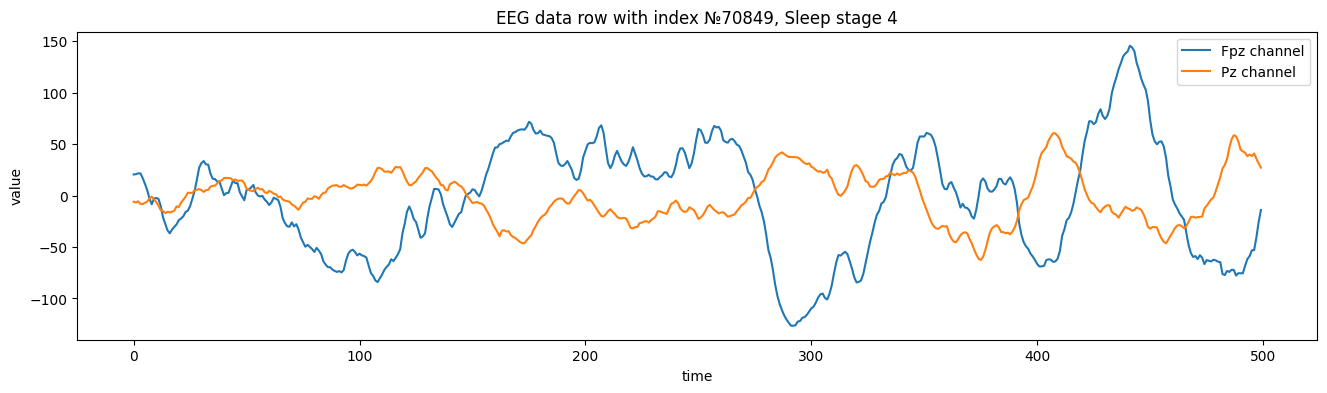

In [10]:
sleep_stages = df.label.unique()
for stage in sleep_stages:
  for _ in range(3):
    i = random.randrange(df[(df.label == stage)].shape[0])
    df_sample = df[(df.label == stage)].iloc[i]
    example_first = get_first_value(df_sample.value)
    example_second = get_second_value(df_sample.value)
    fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
    ax.plot(example_first, label='Fpz channel')
    ax.plot(example_second, label='Pz channel')
    plt.legend()
    plt.title('EEG data row with index №' + str(df_sample.name) + ', ' + df_sample.label)
    plt.xlabel('time')
    plt.ylabel('value')
    plt.show()

Видим, что разные стадии сна и состояние бодрстования отличимы визуально, что вселяет надежду в возможность решения задачи. Также можно заметить данные с артефактами

In [11]:
def set_class(value: str) -> float:
  if value == 'Sleep stage W':
    return 0.0
  else:
    return 1.0

df['condition_class'] = df.label.apply(set_class)
test_df['condition_class'] = test_df.label.apply(set_class)
df.groupby('condition_class').count()

,label,time,value,person,first_value,second_value
condition_class,,,,,,
0.0,231552,231552,231552,231552,231552,231552
1.0,69132,69132,69132,69132,69132,69132


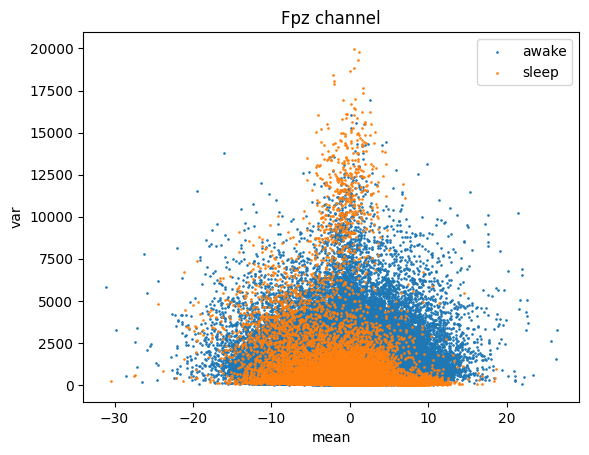

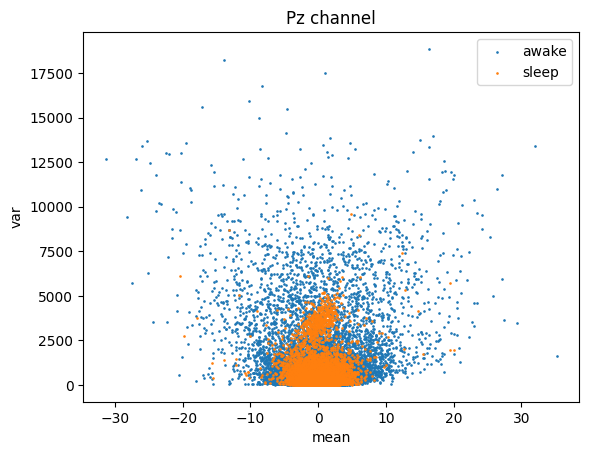

In [12]:
def get_class(value: int) -> str:
  if value == 0.0:
    return 'awake'
  else:
    return 'sleep'

df['first_value_mean'] =  df.first_value.apply(lambda x: x.mean())
df['first_value_var'] =  df.first_value.apply(lambda x: x.var())
df['second_value_mean'] =  df.second_value.apply(lambda x: x.mean())
df['second_value_var'] =  df.second_value.apply(lambda x: x.var())

classes = (df['condition_class'].unique())
colors = ['orange', 'indigo']
alpha = 1
dot_size = 0.8

fig, ax = plt.subplots()
plt.xlabel('mean')
plt.ylabel('var')
for color, condition in zip(colors, classes):
    ax.scatter(df[df['condition_class'] == condition].first_value_mean, df[df['condition_class'] == condition].first_value_var, \
               label=get_class(condition), s = dot_size, alpha=alpha)
ax.legend()
plt.title('Fpz channel')
plt.show()

fig, ax = plt.subplots()
plt.xlabel('mean')
plt.ylabel('var')
for color, condition in zip(colors, classes):
    ax.scatter(df[df['condition_class'] == condition].second_value_mean, df[df['condition_class'] == condition].second_value_var, \
               label=get_class(condition), s = dot_size, alpha=alpha)
ax.legend()
plt.title('Pz channel')
plt.show()

Видно, что по среднему значению и дисперсии классы трудно отличимы. Уберём из выборки ряды с высокой дисперсией. 

In [13]:
df = df[(df.first_value_var < 5000) & (df.second_value_var < 5000)]

In [14]:
df.groupby('label').count()

,time,value,person,first_value,second_value,condition_class,first_value_mean,first_value_var,second_value_mean,second_value_var
label,,,,,,,,,,
Sleep stage 1,9477,9477,9477,9477,9477,9477,9477,9477,9477,9477
Sleep stage 2,50918,50918,50918,50918,50918,50918,50918,50918,50918,50918
Sleep stage 3,4773,4773,4773,4773,4773,4773,4773,4773,4773,4773
Sleep stage 4,3209,3209,3209,3209,3209,3209,3209,3209,3209,3209
Sleep stage W,228293,228293,228293,228293,228293,228293,228293,228293,228293,228293


In [15]:
test_df.groupby('label').count()

,time,value,person,condition_class
label,,,,
Sleep stage 4,8208,8208,8208,8208
Sleep stage W,7488,7488,7488,7488


In [16]:
df.groupby('condition_class').count()

,label,time,value,person,first_value,second_value,first_value_mean,first_value_var,second_value_mean,second_value_var
condition_class,,,,,,,,,,
0.0,228293,228293,228293,228293,228293,228293,228293,228293,228293,228293
1.0,68377,68377,68377,68377,68377,68377,68377,68377,68377,68377


## Experiments

In [17]:
#Small DataFrame to experiment on
small_df_size = 3000

small_df_size = 2 * min(small_df_size // 2, df[df.label == 'Sleep stage 4'].shape[0])
exp_df = shuffle(pd.concat([df[df.label == 'Sleep stage 4'].sample(small_df_size // 2),\
                           df[df.label == 'Sleep stage W'].sample(small_df_size // 2)]))
exp_y = exp_df['condition_class'].to_numpy()
exp_X = exp_df[['first_value', 'second_value']].applymap(pd.Series)

In [18]:
#Train data
fit_data_size = df[df.label == 'Sleep stage 4'].shape[0]

train_df = shuffle(pd.concat([df[df.label == 'Sleep stage 4'], df[df.label == 'Sleep stage W'].sample(fit_data_size)]))
train_y = train_df['condition_class'].to_numpy()
train_X = train_df[['first_value', 'second_value']]
train_X = train_df[['first_value', 'second_value']].applymap(pd.Series)

In [19]:
#Evaluation data
test_df['first_value'] = test_df.value.apply(get_first_value)
test_df['second_value'] = test_df.value.apply(get_second_value)

eval_df = shuffle(test_df[['first_value', 'second_value', 'condition_class']])
eval_X = eval_df[['first_value', 'second_value']].applymap(pd.Series)
eval_y = eval_df['condition_class'].to_numpy()

### tsfresh feature extraction

In [20]:
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh.feature_extraction.feature_calculators import fft_aggregated
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score

Извлекаем всевозможные признаки врменных рядов

In [21]:
extraction_settings = ComprehensiveFCParameters()
extractor = TSFreshFeatureExtractor(show_warnings=False, n_jobs=12, default_fc_parameters=ComprehensiveFCParameters())

X_features = extractor.fit_transform(exp_X)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [03:28<00:00,  3.48s/it]


Определяем и отделяем наиболее интересные признаки

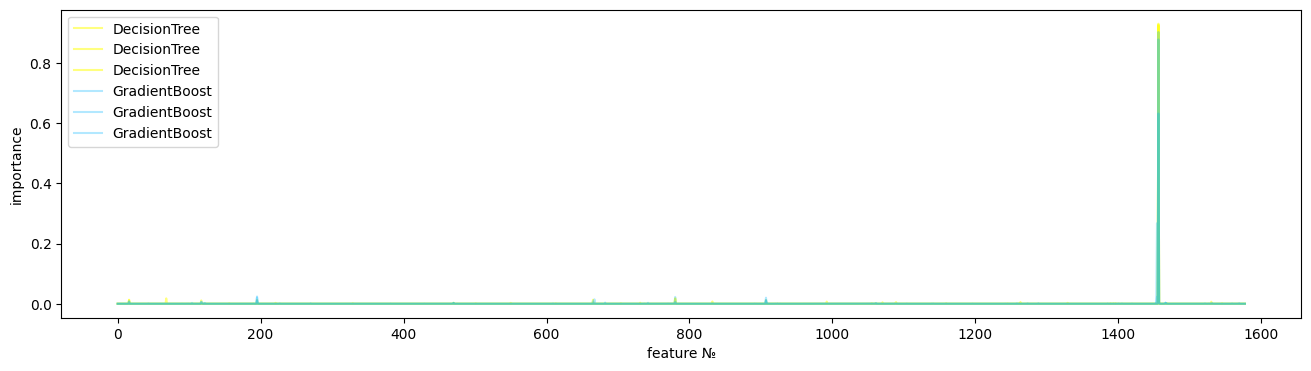

In [22]:
Feature_importances = []
scores = []
x = range(X_features.columns.shape[0])
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
plt.xlabel('feature №')
plt.ylabel('importance')
for i in range(3):
    X_train, X_test, y_train, y_test = train_test_split(X_features, exp_y, test_size=.2)
    dcl = DecisionTreeClassifier(random_state = i)
    dcl.fit(X_train, y_train)
    ax.plot(x, dcl.feature_importances_, color = [1.0,1.0,0.0,0.5], label = 'DecisionTree')
    Feature_importances.append(dcl.feature_importances_)
    scores.append(accuracy_score(y_test, dcl.predict(X_test)))
                                        
for i in range(3):
    X_train, X_test, y_train, y_test = train_test_split(X_features, exp_y, test_size=.2)
    gcl = GradientBoostingClassifier(random_state = i)
    gcl.fit(X_train, y_train)
    ax.plot(x, gcl.feature_importances_, color = [0,0.7,1, 0.3], label = 'GradientBoost')
    Feature_importances.append(gcl.feature_importances_)
    scores.append(accuracy_score(y_test, gcl.predict(X_test)))
plt.legend()
plt.show()

In [23]:
print(*scores)

0.9816666666666667 0.9883333333333333 0.9866666666666667 0.9916666666666667 0.9883333333333333 0.995


Score классификации говорит что результатам выбора признаков можно доверять.
Как видно из графика, существует небольшой устоявшийся набор признаков, которые вносят значительный вклад в классификацию, и виден совпадающий пик, отмеченный зеленым цветом - признак, вносящий наибольший вклад. 

In [24]:
features = set()
for feature_importances in Feature_importances:
    mask = feature_importances > 0.003
    features.update(X_features.columns[mask])
    print(X_features.columns[np.argmax(feature_importances)])

second_value__fft_aggregated__aggtype_"skew"
second_value__fft_aggregated__aggtype_"skew"
second_value__fft_aggregated__aggtype_"skew"
second_value__fft_aggregated__aggtype_"skew"
second_value__fft_aggregated__aggtype_"skew"
second_value__fft_aggregated__aggtype_"skew"


Видим, что признак вносящий наибольший вклад в классификацию - Коэффициент асимметрии амплитуд частотного спектра входного сигнала, полученых с помощью преобразования Фурье.

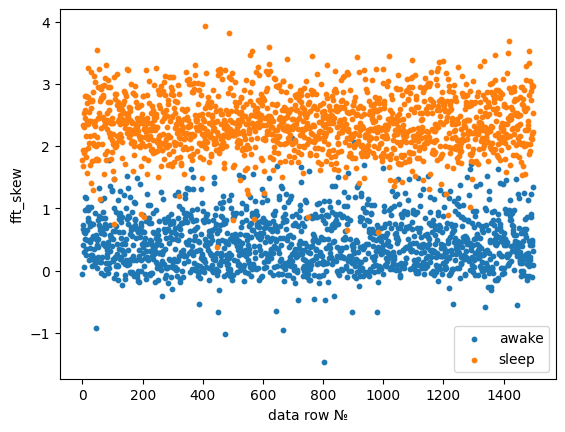

In [25]:
exp_df['fft_skew'] = exp_df.second_value.apply(lambda x: next(fft_aggregated(x, [{"aggtype": 'skew'}]))[1])
plt.scatter(range(small_df_size // 2), exp_df[exp_df.condition_class == 0.0].fft_skew.to_numpy(), label = 'awake', s = 10)
plt.scatter(range(small_df_size // 2), exp_df[exp_df.condition_class == 1.0].fft_skew.to_numpy(), label = 'sleep', s = 10)
plt.xlabel('data row №')
plt.ylabel('fft_skew')
plt.legend()
plt.show()

Видно, что этот признак (fft skew) Pz канала отлично разделяет классы между собой.

Извлечём из обучающего датасета только необходимые признаки.

In [26]:
%%time
t = TSFreshFeatureExtractor(show_warnings=False, n_jobs=12, kind_to_fc_parameters = features)

X_train = t.fit_transform(train_X)
y_train = train_y
X_test = t.transform(eval_X)
y_test = eval_y

Feature Extraction: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [01:38<00:00,  1.64s/it]


CPU times: total: 3min 34s
Wall time: 5min 34s


In [27]:
%%time

param_grid = {
    'max_depth': [1, 2, 3, 4, 5],
    'n_estimators': [10, 100, 200]
}

cl = GradientBoostingClassifier(random_state = 1)
grid_search = GridSearchCV(estimator = cl, param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 4)
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 15 candidates, totalling 150 fits
CPU times: total: 9.48 s
Wall time: 45.1 s


GridSearchCV(cv=10, estimator=GradientBoostingClassifier(random_state=1),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5],
                         'n_estimators': [10, 100, 200]},
             verbose=4)

In [28]:
best_cl = grid_search.best_estimator_
best_parameters = grid_search.best_params_
print('Наилучший результат: %0.3f' % grid_search.best_score_)
print('Наилучшие параметры: ')
for param_name in sorted(best_parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

y_pred = best_cl.predict(X_test)

print('acc ' + str(accuracy_score(y_test, y_pred)))
print('precision ' + str(precision_score(y_test, y_pred, average=None)))
print('recall ' + str(recall_score(y_test, y_pred, average=None)))

Наилучший результат: 0.992
Наилучшие параметры: 
	max_depth: 5
	n_estimators: 200
acc 0.9871941896024465
precision [0.98586478 0.98841039]
recall [0.98731303 0.98708577]


In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      7488
         1.0       0.99      0.99      0.99      8208

    accuracy                           0.99     15696
   macro avg       0.99      0.99      0.99     15696
weighted avg       0.99      0.99      0.99     15696



Видно, что фичи были подобраны хорошо и классификация проходит с высокой точностью

### Rocket transform

In [30]:
from sklearn.linear_model import RidgeClassifierCV
from sktime.transformations.panel.rocket import Rocket

In [31]:
%%time
rocket = Rocket(n_jobs = 12)
rocket.fit(exp_X)

CPU times: total: 20.5 s
Wall time: 20.6 s


Rocket(n_jobs=12)

In [32]:
%%time
X_transformed = rocket.transform(train_X)
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
classifier.fit(X_transformed, train_y)

C:\Users\lexzh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alphas to: original_alphas * n_samples. 
  warnings.warn(


CPU times: total: 18min 38s
Wall time: 2min 30s


RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                  normalize=True)

In [ ]:
%%time
# Подготовим данные для валидации
X_test = rocket.transform(eval_X)

In [ ]:
%%time
y_pred = classifier.predict(X_test)
y_test = eval_y

print('acc ' + str(accuracy_score(y_test, y_pred)))
print('precision ' + str(precision_score(y_test, y_pred, average=None)))
print('recall ' + str(recall_score(y_test, y_pred, average=None)))

## Выводы

Видно что состояния сна и бодрствования хорошо отличимы, даже классификатор на основе решающего дерева выдает очень хорошие результаты, основываясь на выделенных фичах.

Преобразование со случайными сверточными ядрами дает более высокие показатели точности и работает быстрее.

Уверен, что для реальных задач расознавания стадий сна будет полезно использовать частотные фильтры на входных данных, более детально изучить какие фичи помогут отличить стадии сна друг от друга.
Существуют статьи, показывающие целесообразность использования CNN и LSTM для анализа данных EEG, а также успех Rocket подкрепляет целесообразность проведения дальнейших экспериментов с CNN и глубокими сетями. 